# Benchmark Analysis - H8

In [2]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

%matplotlib inline

In [4]:
matplotlib.style.use('seaborn-v0_8')  

In [5]:
device_name = 'nebulac'
core_list = [1,2,4,8,16,32,64]

In [6]:
root_dir = '/Users/diego/Desktop/BENCHMARK_NEBULAC_ALL_67M_WITH_BYTES'

In [7]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'brown'


In [8]:
plot_save_dir = './plots/h8'

## Utils 

In [9]:
def get_path(*entries):
    return os.path.join(*entries)

In [10]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [11]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [12]:
def extraction_pandas_frame_algo(path, COMP="TODO",include_bytes_per_second=False):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                    axis=1)

    if not include_bytes_per_second:
        df = df.drop(columns=['bytes_per_second'])

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev','max','min'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 5 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 5 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    # set max bytes per second
    results_gcc['max_id'] = results_gcc['C'] * 5 + 3
    
    # max bytes per seconds as bytes per second
    if include_bytes_per_second:
        results_gcc['bytes_per_second'] = results_gcc['max_id'].apply(lambda x: df.iloc[x]['bytes_per_second'])

    # min time as real_time
    results_gcc['min_id'] = results_gcc['C'] * 5 + 4
    results_gcc['real_time'] = results_gcc['min_id'].apply(lambda x: df.iloc[x]['real_time'])


    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id','min_id','max_id'], axis=1)
    results_gcc['Compiler'] = 'COMP'
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [13]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [14]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [15]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [16]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [17]:
def get_seq_base(benchmark_name:str) -> pd.DataFrame:

    time_filed_name = 'real_time'

    compiler_instances = [
        ('GCC_TBB','GCC(TBB)'),
        ('NVHPC_Multicore','NVC(OMP)')
    ]

    start_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[0][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
    min_val = start_df[time_filed_name].min()
    min_df = start_df


    for i in range(1,len(compiler_instances)):
        current_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[i][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
        current_min = current_df[time_filed_name].min()

        if current_min < min_val:
            min_val = current_min
            min_df = current_df

    return min_df

In [18]:
def get_strong_scaling_algo(compiler_location:str,compiler_name:str,bench_name:str,base_of:Optional[str]=None) -> pd.DataFrame:
    
    if base_of is None:
        ## seq base
        seq_base = get_seq_base(bench_name)
    else:
        seq_base = get_seq_base(base_of)

    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

# H8

> Parallel STL does not inherently provide support for index-based iterations, thereby requiring the developer to devise
> a custom sequence for indices. The manner in which the index values are generated by the developer can significantly
> impact the application's performance and scalability.

## `b9_1_transform_baseline`

In [19]:
benchmark_name = "b9_1_transform_baseline"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_1_transform_baseline`

Check how the runtime without constraining the threads develops with increasing input size

In [20]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_1_transform_baseline_time_merged = pd.merge(*data, on='n')

b9_1_transform_baseline_time_merged

,GCC(TBB),n,NVC(OMP)
0,5394.45,4,10947.7
1,10498.60,8,11510.8
2,16194.50,16,12485.8
3,22728.90,32,12654.7
4,25887.00,64,12938.4
5,27238.50,128,12539.6
6,29625.70,256,12390.4
7,33075.70,512,11625.5
8,38105.70,1024,11002.9
9,42624.90,2048,11062.8


### Strong Scaling - `b9_1_transform_baseline`
 
2^26 fixed input size with threads 1-64

In [21]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_1_transform_baseline_strong_scaling_merged = pd.merge(*data, on='threads')

b9_1_transform_baseline_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.032455,0.114633
1,2,1.339310,0.228611
2,4,3.080718,0.457328
3,8,3.610267,0.913221
4,16,4.447975,1.823944
5,32,4.689628,3.633540
6,64,4.941543,7.001848


In [22]:
## efficiency graph

b9_1_transform_baseline_efficiency = b9_1_transform_baseline_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_1_transform_baseline_efficiency[f'{compiler_name}'] = b9_1_transform_baseline_efficiency[f'{compiler_name}'] / b9_1_transform_baseline_efficiency['threads']



b9_1_transform_baseline_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.032455,0.114633
1,2,0.669655,0.114306
2,4,0.770180,0.114332
3,8,0.451283,0.114153
4,16,0.277998,0.113996
5,32,0.146551,0.113548
6,64,0.077212,0.109404


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_50411/678994611.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


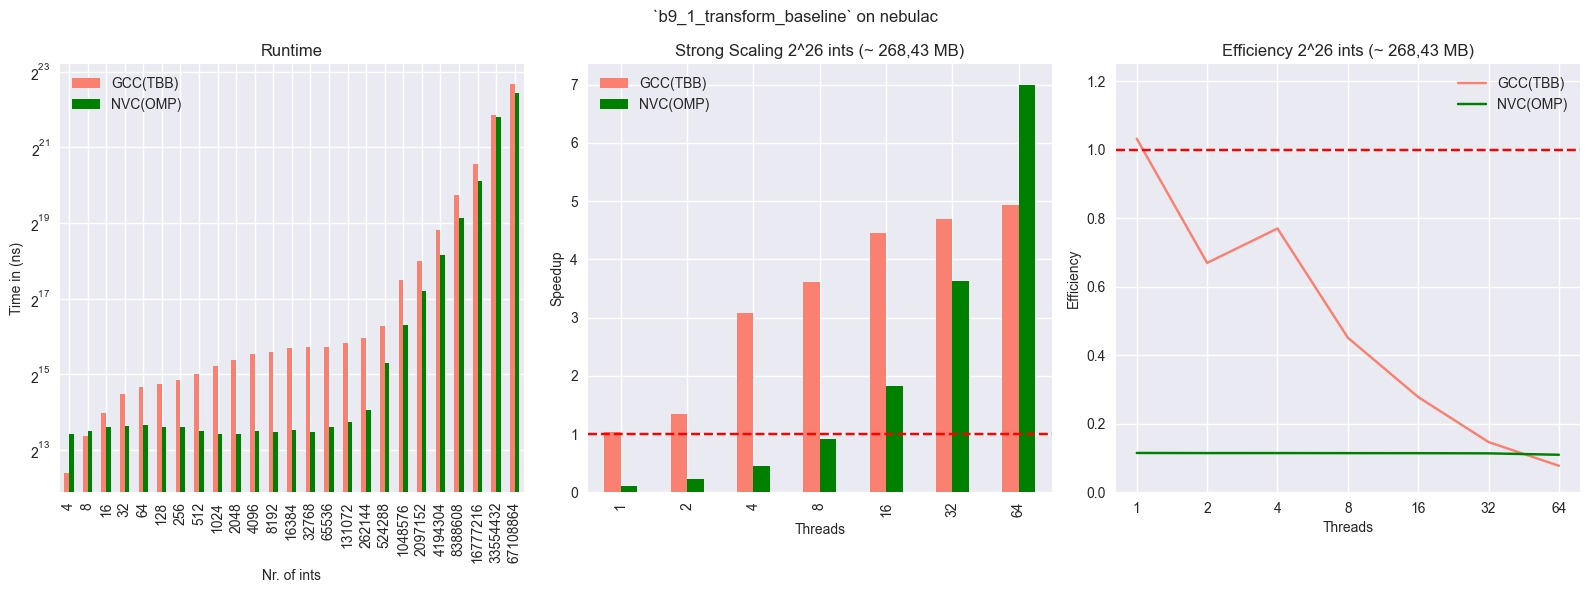

In [23]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_1_transform_baseline_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_1_transform_baseline_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_1_transform_baseline_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b9_1_transform_baseline` on {device_name}")

fig.tight_layout()

plot(f"`b9_1_transform_baseline` {device_name}")

## `b9_2_transform_old_iota`

In [24]:
benchmark_name = "b9_2_transform_old_iota"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_2_transform_old_iota`

Check how the runtime without constraining the threads develops with increasing input size

In [25]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_2_transform_old_iota_time_merged = pd.merge(*data, on='n')

b9_2_transform_old_iota_time_merged

,GCC(TBB),n,NVC(OMP)
0,5.638630e+03,4,10039.5
1,1.060260e+04,8,10025.2
2,1.716420e+04,16,10424.6
3,2.207210e+04,32,11711.9
4,2.703920e+04,64,13331.4
5,2.905820e+04,128,12372.5
6,3.258640e+04,256,12209.3
7,3.903180e+04,512,13804.0
8,4.425940e+04,1024,16913.6
9,5.316000e+04,2048,21659.9


### Strong Scaling - `b9_2_transform_old_iota`
 
2^26 fixed input size with threads 1-64

In [26]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_2_transform_old_iota_strong_scaling_merged = pd.merge(*data, on='threads')

b9_2_transform_old_iota_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.001695,0.484925
1,2,1.131978,0.736987
2,4,1.225408,0.993919
3,8,1.230916,1.141541
4,16,1.134158,1.112920
5,32,1.104711,1.130449
6,64,1.145605,1.126355


In [27]:
## efficiency graph

b9_2_transform_old_iota_efficiency = b9_2_transform_old_iota_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_2_transform_old_iota_efficiency[f'{compiler_name}'] = b9_2_transform_old_iota_efficiency[f'{compiler_name}'] / b9_2_transform_old_iota_efficiency['threads']



b9_2_transform_old_iota_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.001695,0.484925
1,2,0.565989,0.368494
2,4,0.306352,0.248480
3,8,0.153864,0.142693
4,16,0.070885,0.069557
5,32,0.034522,0.035327
6,64,0.017900,0.017599


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_50411/1659612440.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


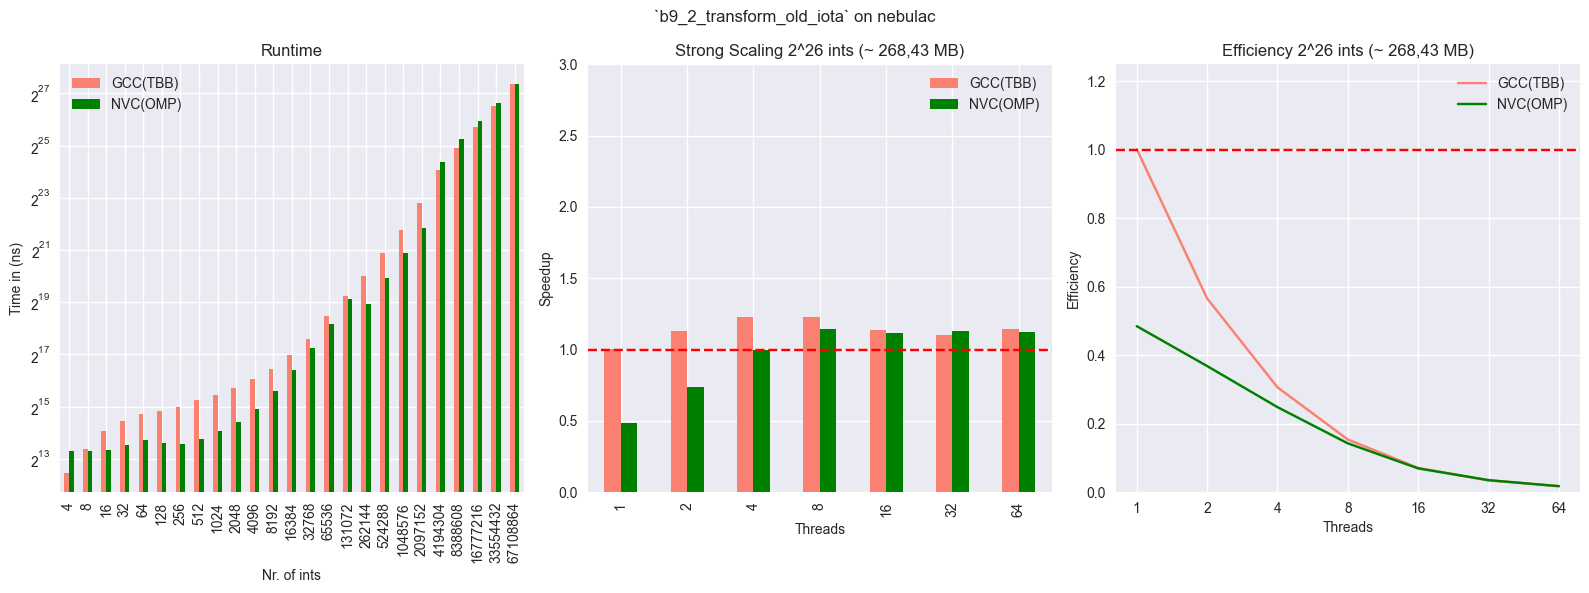

In [28]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_2_transform_old_iota_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_2_transform_old_iota_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_2_transform_old_iota_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b9_2_transform_old_iota` on {device_name}")

fig.tight_layout()

plot(f"`b9_2_transform_old_iota` {device_name}")

## `b9_3_transform_views_iota`

In [29]:
benchmark_name = "b9_3_transform_views_iota"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_3_transform_views_iota`

Check how the runtime without constraining the threads develops with increasing input size

In [30]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_3_transform_views_iota_time_merged = pd.merge(*data, on='n')

b9_3_transform_views_iota_time_merged

,GCC(TBB),n,NVC(OMP)
0,4.859510e+01,4,9990.24
1,4.859520e+01,8,9981.35
2,4.919220e+01,16,10044.80
3,5.043880e+01,32,11434.00
4,5.111920e+01,64,12611.60
5,7.118490e+01,128,11507.60
6,1.272970e+02,256,10827.50
7,1.933450e+02,512,10807.90
8,3.217070e+02,1024,11554.10
9,5.785350e+02,2048,11664.80


### Strong Scaling - `b9_3_transform_views_iota`
 
2^26 fixed input size with threads 1-64

In [31]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_3_transform_views_iota_strong_scaling_merged = pd.merge(*data, on='threads')

b9_3_transform_views_iota_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.995467,0.117707
1,2,0.989566,0.235048
2,4,0.978570,0.468793
3,8,0.711921,0.936575
4,16,0.657724,1.866088
5,32,0.669467,3.728000
6,64,0.678167,7.414784


In [32]:
## efficiency graph

b9_3_transform_views_iota_efficiency = b9_3_transform_views_iota_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_3_transform_views_iota_efficiency[f'{compiler_name}'] = b9_3_transform_views_iota_efficiency[f'{compiler_name}'] / b9_3_transform_views_iota_efficiency['threads']



b9_3_transform_views_iota_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.995467,0.117707
1,2,0.494783,0.117524
2,4,0.244642,0.117198
3,8,0.088990,0.117072
4,16,0.041108,0.116631
5,32,0.020921,0.116500
6,64,0.010596,0.115856


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_50411/1164897114.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


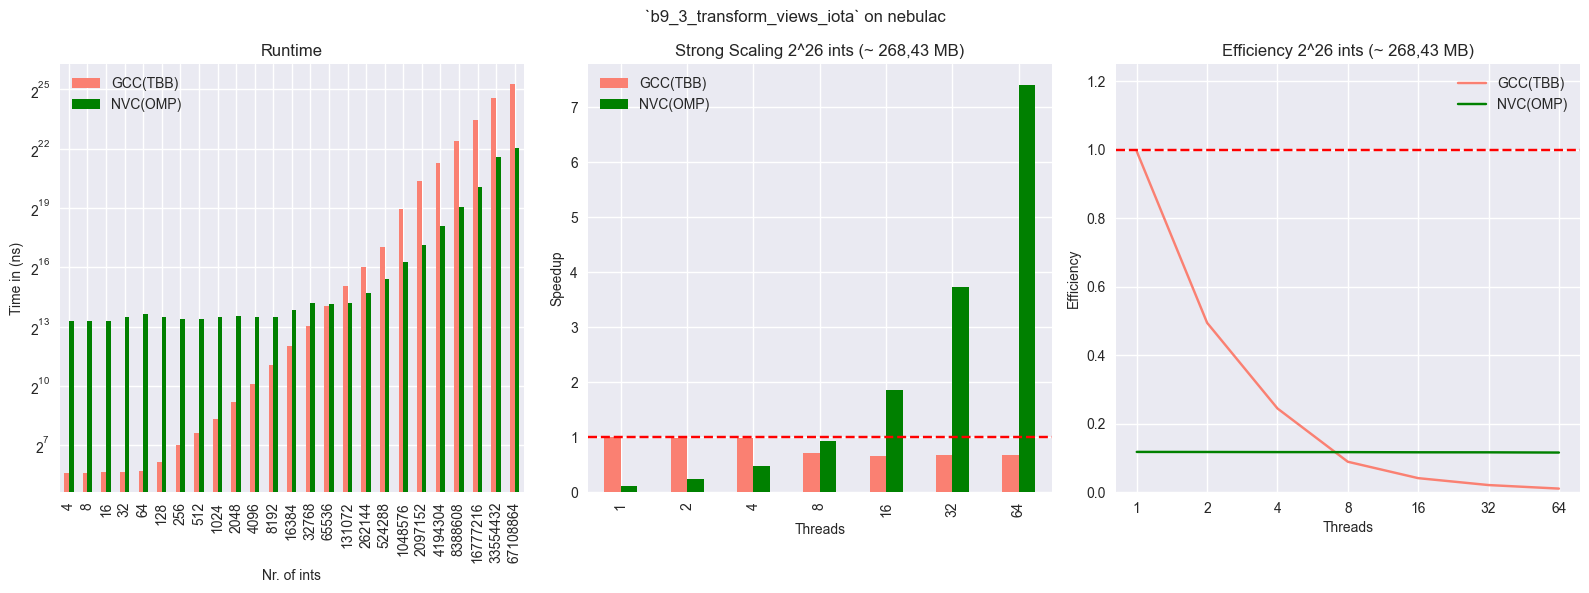

In [33]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_3_transform_views_iota_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_3_transform_views_iota_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_3_transform_views_iota_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b9_3_transform_views_iota` on {device_name}")

fig.tight_layout()

plot(f"`b9_3_transform_views_iota` {device_name}")

## `b9_5_transform_custom_iterator`

In [34]:
benchmark_name = "b9_5_transform_custom_iterator"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_5_transform_custom_iterator`

Check how the runtime without constraining the threads develops with increasing input size

In [35]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_5_transform_custom_iterator_time_merged = pd.merge(*data, on='n')

b9_5_transform_custom_iterator_time_merged

,GCC(TBB),n,NVC(OMP)
0,5724.97,4,9375.99
1,10775.30,8,9746.95
2,17039.70,16,10775.00
3,21679.30,32,11807.80
4,26708.80,64,12005.20
5,27904.00,128,11552.50
6,30624.90,256,10711.80
7,33356.40,512,10905.60
8,38312.80,1024,10374.20
9,42690.90,2048,11624.80


### Strong Scaling - `b9_5_transform_custom_iterator`
 
2^26 fixed input size with threads 1-64

In [36]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_5_transform_custom_iterator_strong_scaling_merged = pd.merge(*data, on='threads')

b9_5_transform_custom_iterator_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.988063,0.118146
1,2,1.302790,0.236359
2,4,3.038093,0.470132
3,8,3.507077,0.939988
4,16,4.271731,1.884809
5,32,4.563576,3.737125
6,64,4.760971,7.374891


In [37]:
## efficiency graph

b9_5_transform_custom_iterator_efficiency = b9_5_transform_custom_iterator_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_5_transform_custom_iterator_efficiency[f'{compiler_name}'] = b9_5_transform_custom_iterator_efficiency[f'{compiler_name}'] / b9_5_transform_custom_iterator_efficiency['threads']



b9_5_transform_custom_iterator_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.988063,0.118146
1,2,0.651395,0.118180
2,4,0.759523,0.117533
3,8,0.438385,0.117498
4,16,0.266983,0.117801
5,32,0.142612,0.116785
6,64,0.074390,0.115233


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_50411/2319354240.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


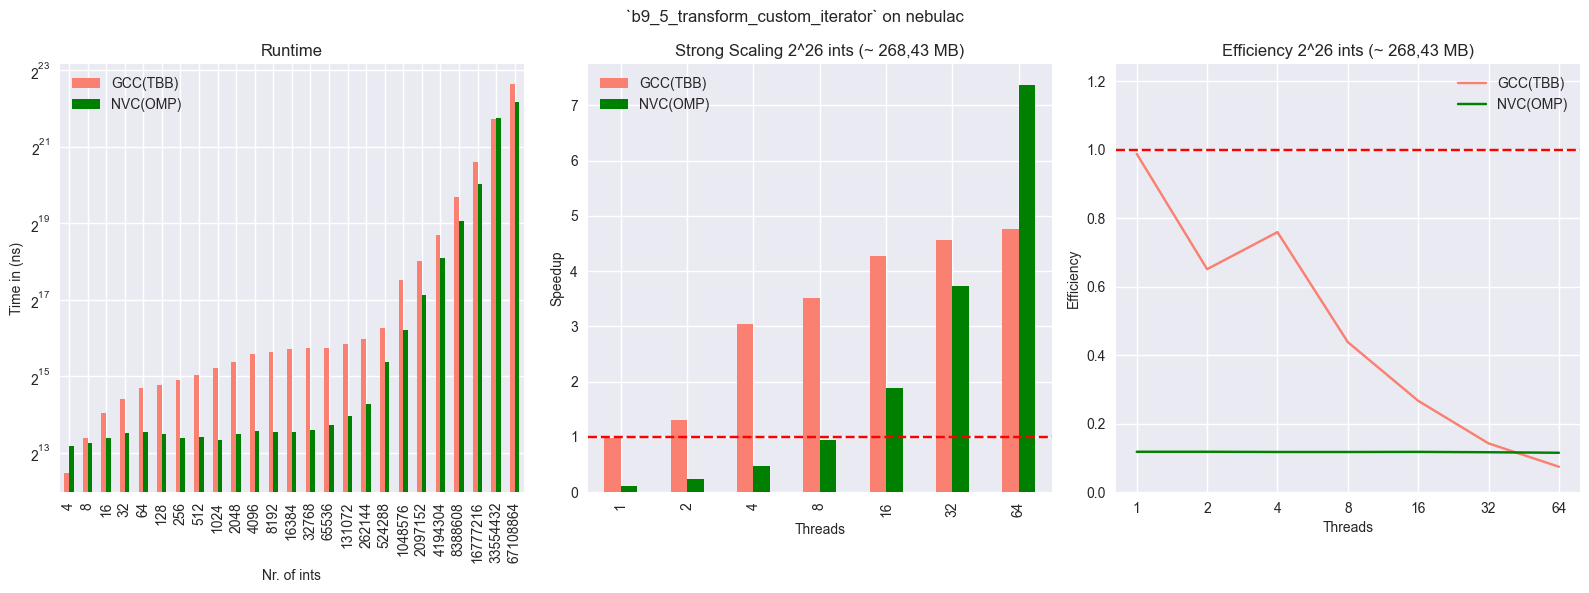

In [38]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_5_transform_custom_iterator_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_5_transform_custom_iterator_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_5_transform_custom_iterator_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b9_5_transform_custom_iterator` on {device_name}")

fig.tight_layout()

plot(f"`b9_5_transform_custom_iterator` {device_name}")

## `b9_6_transform_boost`

In [39]:
benchmark_name = "b9_6_transform_boost"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_6_transform_boost`

Check how the runtime without constraining the threads develops with increasing input size

In [40]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_6_transform_boost_time_merged = pd.merge(*data, on='n')

b9_6_transform_boost_time_merged

,GCC(TBB),n,NVC(OMP)
0,6352.2,4,10762.0
1,15075.4,8,11122.7
2,21366.7,16,10881.6
3,26194.1,32,12820.1
4,30012.4,64,13166.6
5,31696.8,128,12534.8
6,33376.4,256,11567.2
7,35502.9,512,11374.9
8,39091.8,1024,12272.6
9,43973.9,2048,11551.3


### Strong Scaling - `b9_6_transform_boost`
 
2^26 fixed input size with threads 1-64

In [41]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_6_transform_boost_strong_scaling_merged = pd.merge(*data, on='threads')

b9_6_transform_boost_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.005079,0.119382
1,2,1.322721,0.238601
2,4,3.107555,0.474480
3,8,3.533835,0.952404
4,16,4.517544,1.894095
5,32,4.678356,3.774481
6,64,4.858056,7.427557


In [42]:
## efficiency graph

b9_6_transform_boost_efficiency = b9_6_transform_boost_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_6_transform_boost_efficiency[f'{compiler_name}'] = b9_6_transform_boost_efficiency[f'{compiler_name}'] / b9_6_transform_boost_efficiency['threads']



b9_6_transform_boost_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.005079,0.119382
1,2,0.661360,0.119300
2,4,0.776889,0.118620
3,8,0.441729,0.119051
4,16,0.282347,0.118381
5,32,0.146199,0.117953
6,64,0.075907,0.116056


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_50411/91003008.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


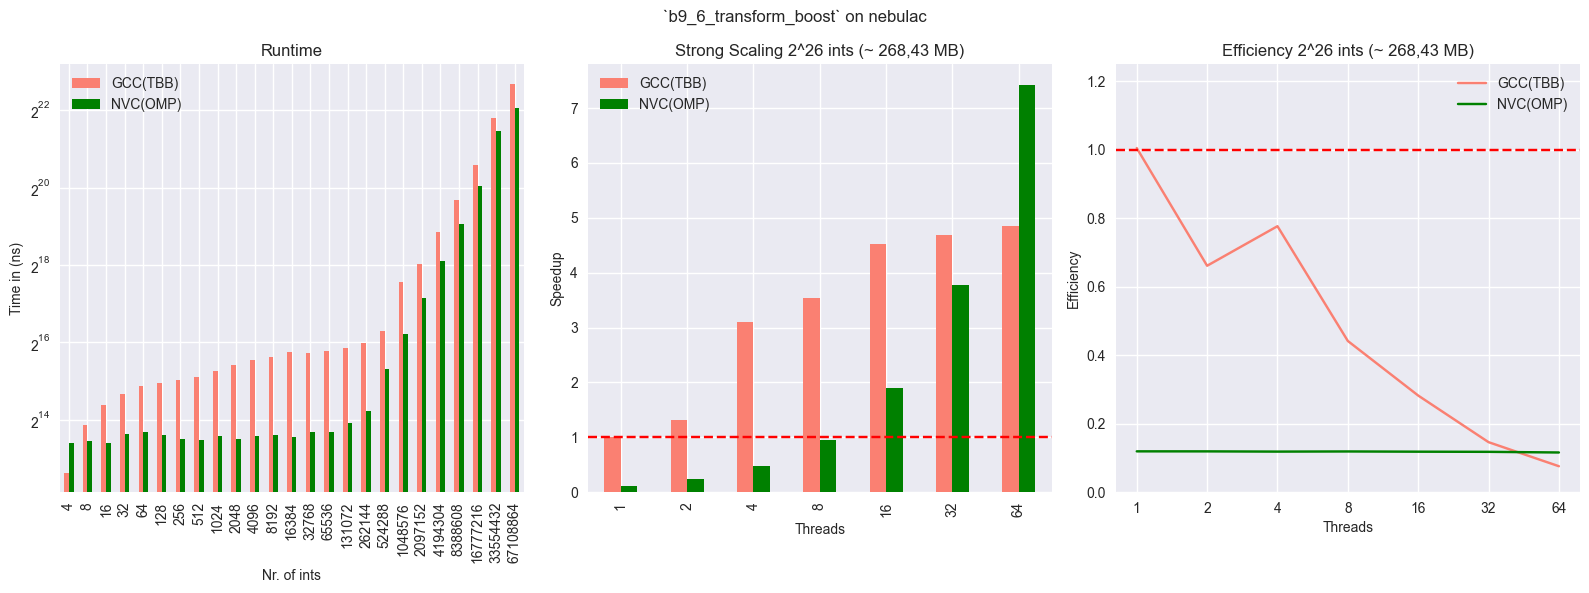

In [43]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_6_transform_boost_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_6_transform_boost_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_6_transform_boost_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle(f"`b9_6_transform_boost` on {device_name}")

fig.tight_layout()

plot(f"`b9_6_transform_boost` {device_name}")

## Speedup comparison per strategy

In [44]:
impl_index_versions = [
    ('b9_1_transform_baseline'),
    ('b9_2_transform_old_iota'),
    ('b9_3_transform_views_iota'),
    ('b9_5_transform_custom_iterator'),
    ('b9_6_transform_boost'),
]

base_of = "b9_1_transform_baseline"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

data_index_strategies_speedup : Dict[str,pd.DataFrame] = {}
data_index_strategies_efficiency : Dict[str,pd.DataFrame] = {}

for compiler_location, compiler_name in instances:
    data = [get_strong_scaling_algo(compiler_location,bench_name,bench_name,base_of) for bench_name in impl_index_versions ]

    # speedup data collector 
    data_index_strategies_speedup[compiler_name] = data[0]

    for i in range(1,len(data)):
        data_index_strategies_speedup[compiler_name] = pd.merge(data_index_strategies_speedup[compiler_name],data[i],on='threads')

    # efficiency 
    data_index_strategies_efficiency[compiler_name] = data_index_strategies_speedup[compiler_name].copy()

    for strat in impl_index_versions:
        data_index_strategies_efficiency[compiler_name][strat] = data_index_strategies_efficiency[compiler_name][strat] / data_index_strategies_efficiency[compiler_name]['threads']

data_index_strategies_efficiency[instances[0][1]]



,threads,b9_1_transform_baseline,b9_2_transform_old_iota,b9_3_transform_views_iota,b9_5_transform_custom_iterator,b9_6_transform_boost
0,1,1.032455,0.168140,1.019794,1.014018,1.014902
1,2,0.669655,0.095004,0.506874,0.668506,0.667824
2,4,0.770180,0.051423,0.250621,0.779475,0.784482
3,8,0.451283,0.025827,0.091165,0.449900,0.446047
4,16,0.277998,0.011898,0.042112,0.273996,0.285106
5,32,0.146551,0.005795,0.021432,0.146358,0.147627
6,64,0.077212,0.003005,0.010855,0.076344,0.076649


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_50411/2214280357.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_50411/2214280357.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


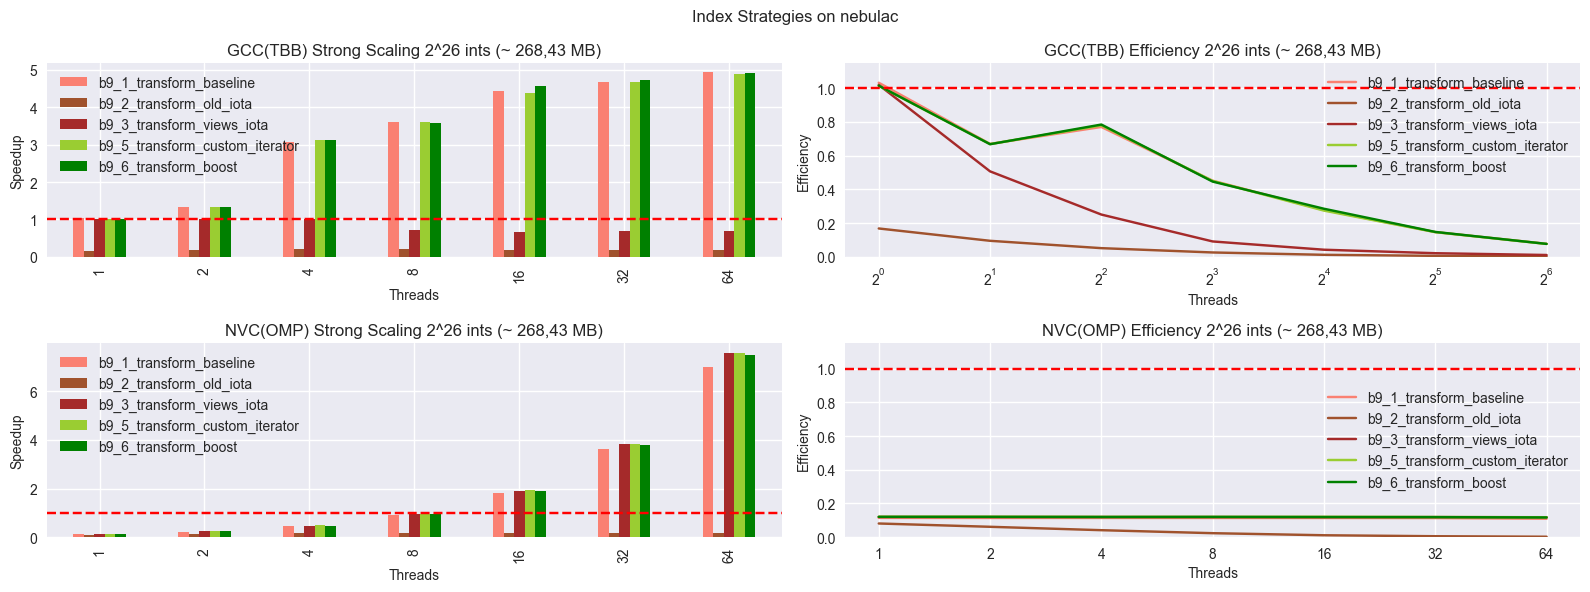

In [45]:
# graphs 

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 6))


# plot strong scaling
ax_2 = data_index_strategies_speedup['GCC(TBB)'].plot(kind='bar',
                                                                    x='threads',
                                                                    align='center',
                                                                    color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_GPU_COLOR,NVC_OMP_COLOR_SECONDARY,NVC_OMP_COLOR],
                                                                    ax=axes[0,0]
                                                                    )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('GCC(TBB) Strong Scaling 2^26 ints (~ 268,43 MB)')




# plot efficiency
ax_3 = data_index_strategies_efficiency['GCC(TBB)'].plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_GPU_COLOR,NVC_OMP_COLOR_SECONDARY,NVC_OMP_COLOR],
                                                            ax=axes[0,1]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.15)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('GCC(TBB) Efficiency 2^26 ints (~ 268,43 MB)')







# plot strong scaling
ax_1 = data_index_strategies_speedup['NVC(OMP)'].plot(kind='bar',
                                                                    x='threads',
                                                                    align='center',
                                                                    color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_GPU_COLOR,NVC_OMP_COLOR_SECONDARY,NVC_OMP_COLOR],
                                                                    ax=axes[1,0]
                                                                    )

# adding horizontal line where there is speedup
ax_1.axhline(y=1, color='r', linestyle='--')

#ax_1.set_ylim(0,3)
ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Threads')
ax_1.set_title('NVC(OMP) Strong Scaling 2^26 ints (~ 268,43 MB)')




# plot efficiency
ax_4 = data_index_strategies_efficiency['NVC(OMP)'].plot(x='threads',
                                                            color=[GCC_TBB_COLOR,GCC_TBB_COLOR_SECONDARY,NVC_GPU_COLOR,NVC_OMP_COLOR_SECONDARY,NVC_OMP_COLOR],
                                                            ax=axes[1,1]
                                                            )

# adding horizontal line where there is speedup
ax_4.axhline(y=1, color='r', linestyle='--')

ax_4.set_ylim(0,1.15)

ax_4.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_4.set_ylabel('Efficiency')
ax_4.set_xlabel('Threads')
ax_4.set_title('NVC(OMP) Efficiency 2^26 ints (~ 268,43 MB)')











fig.suptitle(f"Index Strategies on {device_name}")

fig.tight_layout()

plot(f"Index Strategies on {device_name}")


######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

TODO

In [46]:
# calc pp_metrics

def calc_pp(data_points:List[int]) -> int:
    min_val = min(data_points)
    return len(data_points) / sum([1/(min_val/val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('b9_1_transform_baseline',b9_1_transform_baseline_time_merged),
    ('b9_2_transform_old_iota',b9_2_transform_old_iota_time_merged),
    ('b9_3_transform_views_iota',b9_3_transform_views_iota_time_merged),
    ('b9_5_transform_custom_iterator',b9_5_transform_custom_iterator_time_merged),
    ('b9_6_transform_boost',b9_6_transform_boost_time_merged),
]

for data in data_fields:

    entry_dict = {
        'name': [data[0]],
    }

    vals = []

    for comp in compilers:
        current_val = int(data[1].iloc[-1][comp])
        entry_dict[comp] = [current_val]

        vals.append(current_val)

    entry_dict['PP'] = calc_pp(vals)

    other_df = pd.DataFrame.from_dict(entry_dict)
    pp_df = pd.concat([pp_df,other_df],ignore_index=True)


pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')

pp_df['GCC(TBB)'] = pp_df['GCC(TBB)'].astype('int')
pp_df['NVC(OMP)'] = pp_df['NVC(OMP)'].astype('int')

pp_df


,name,GCC(TBB),NVC(OMP),PP,INTERPRET
0,b9_1_transform_baseline,6746610,5662400,0.912627,GOOD
1,b9_2_transform_old_iota,173627000,173347000,0.999193,GOOD
2,b9_3_transform_views_iota,40935900,4309800,0.190507,BAD
3,b9_5_transform_custom_iterator,6590120,4708240,0.833438,BAD
4,b9_6_transform_boost,6748140,4327940,0.781493,BAD


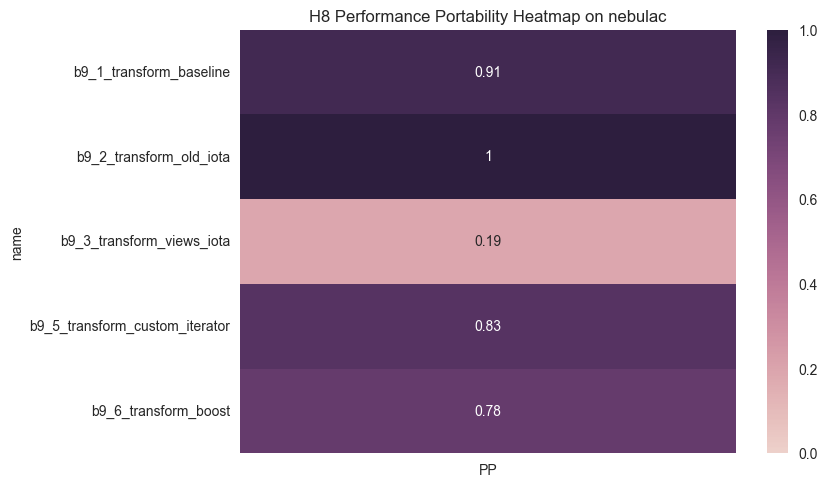

In [47]:
import seaborn as sns

heatmap_pp_df = pp_df.copy()
heatmap_pp_df = heatmap_pp_df.drop(columns=['GCC(TBB)','NVC(OMP)','INTERPRET'])
heatmap_pp_df = heatmap_pp_df.set_index(['name'])


sns.heatmap(heatmap_pp_df, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1)

plt.title(f'H8 Performance Portability Heatmap on {device_name}')

plot(f'H8 Performance Portability Heatmap on {device_name}')

In [48]:
# saving pp into file
pp_save_location = f'/Users/diego/Documents/Studium/4_Semester/Masterarbeit/master_benchmarks/analysis/Performance_Portability/data/{device_name.upper()}_H8_pp.csv'
pp_df.to_csv(pp_save_location)

## Runtime difference between types

In [49]:
print('========= GCC(TBB) =========')

print('= ALL')
all_gcc_tbb = pp_df['GCC(TBB)']

print('\tStddev:',all_gcc_tbb.std())
print('\tPerformance Portability between types of indices:',calc_pp(all_gcc_tbb.tolist()))

print()
print('= ONLY EFFICIENT')
only_efficient = pp_df[pp_df['name'] != 'b9_2_transform_old_iota']['GCC(TBB)']

print('\tStddev:',only_efficient.std())
print('\tPerformance Portability between types of indices:',calc_pp(only_efficient.tolist()))



========= GCC(TBB) =========
= ALL
	Stddev: 72361335.784695
	Performance Portability between types of indices: 0.14042579650341447

= ONLY EFFICIENT
	Stddev: 17120632.168311574
	Performance Portability between types of indices: 0.43199192668332437


In [50]:
print('========= NVC(OMP) =========')

print('= ALL')
all_gcc_tbb = pp_df['NVC(OMP)']

print('\tStddev:',all_gcc_tbb.std())
print('\tPerformance Portability between types of indices:',calc_pp(all_gcc_tbb.tolist()))

print()
print('= ONLY EFFICIENT')
only_efficient = pp_df[pp_df['name'] != 'b9_2_transform_old_iota']['NVC(OMP)']

print('\tStddev:',only_efficient.std())
print('\tPerformance Portability between types of indices:',calc_pp(only_efficient.tolist()))


========= NVC(OMP) =========
= ALL
	Stddev: 75399933.19684096
	Performance Portability between types of indices: 0.11202701998769153

= ONLY EFFICIENT
	Stddev: 634063.8204208364
	Performance Portability between types of indices: 0.9069263135522332


## Findings for H8

### XXX

### General


### GPU Findings


### Hypothesis Findings


